### Problem
The purpose of this study is to analyze the flight booking dataset from the “Ease My Trip” website, using various statistical hypothesis tests to see which variables affect the most. Then, machine learning algorithms will predict the prices and compare them to see which is more effective for this task.

### Dataset
This dataset contains information about flight booking options from the website Easemytrip for travel between India's top 6 metro cities. The cleaned dataset has 300153 observations and 11 features.

Source: https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction/data

In [4]:
# Step 0. Import libraries, custom modules and logging
import kagglehub
import joblib
import logging
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             r2_score,
                             root_mean_squared_error)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import (OneHotEncoder,
                                   MinMaxScaler,
                                  )
from sklearn.inspection import permutation_importance
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)


### 1. Data loading
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [6]:
# 1. Create dataframe
path = kagglehub.dataset_download("shubhambathwal/flight-price-prediction")
df_raw = pd.read_csv('/home/codespace/.cache/kagglehub/datasets/shubhambathwal/flight-price-prediction/versions/2/Clean_Dataset.csv')

100%|██████████| 4.16M/4.16M [00:00<00:00, 44.2MB/s]

Extracting files...


In [7]:
# 1.1 Read from source and get basic info
df_raw.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [8]:
df_raw.sample(10, random_state=2024)

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
188141,188141,Vistara,UK-838,Chennai,Night,one,Afternoon,Mumbai,Economy,17.92,7,11069
76293,76293,Air_India,AI-809,Mumbai,Morning,one,Evening,Hyderabad,Economy,9.33,42,4593
154012,154012,Indigo,6E-913,Hyderabad,Morning,one,Night,Delhi,Economy,11.00,15,9073
112678,112678,GO_FIRST,G8-790,Bangalore,Afternoon,one,Night,Hyderabad,Economy,8.17,27,4801
147683,147683,Vistara,UK-778,Kolkata,Afternoon,one,Afternoon,Hyderabad,Economy,21.25,46,5632
29584,29584,Indigo,6E-552,Delhi,Early_Morning,zero,Morning,Hyderabad,Economy,2.25,9,5955
118219,118219,Air_India,AI-9517,Bangalore,Evening,one,Early_Morning,Chennai,Economy,12.50,33,5221
101933,101933,Indigo,6E-841,Bangalore,Afternoon,one,Evening,Mumbai,Economy,5.17,45,4105
274910,274910,Vistara,UK-874,Hyderabad,Morning,one,Night,Delhi,Business,12.17,5,57990
126582,126582,Indigo,6E-7583,Kolkata,Afternoon,one,Night,Delhi,Economy,6.33,44,5198


## **Data Dictionary**
|Name|Description|Units|Type|
|----|-----------|-----|----|
|airline|The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.|none|category|
|flight|Flight stores information regarding the plane's flight code. It is a categorical feature.|none|category|
|Source City|City from which the flight takes off. It is a categorical feature having 6 unique cities.|none|category|
|Departure Time|This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.|none|category|
|Stops| A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.|none|category|
|Arrival Time| This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.|none|category|
|Destination City| City where the flight will land. It is a categorical feature having 6 unique cities.|none|category|
|Class| A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.|none|category|
|Duration| A continuous feature that displays the overall amount of time it takes to travel between cities in hours.|hours|float|
|Price| Target variable stores information of the ticket price.|Indian rupees|int|

### 2. Data preprocessing
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [9]:
 #Step 2. Prepare the dataset for analysis
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ', '_') # reemplazar espacio por _
        .str.replace(r'\W','',regex=True) # reemplazar caracteres no alfabéticos por nada
        .str.lower() # el resultado lo pasamos a minúsculas
        .str.slice(0,40), axis=1, # slice sirve para cortar el texto a un máximo de 40 caracteres
    )
    .rename(columns={'price':'target'})
    .iloc[:,1:]
    .drop("flight", axis = 1)
    .astype({"airline": "category", "source_city": "category", "departure_time": "category", "stops": "category", "arrival_time": "category", "destination_city": "category", "class": "category"})


)
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   airline           300153 non-null  category
 1   source_city       300153 non-null  category
 2   departure_time    300153 non-null  category
 3   stops             300153 non-null  category
 4   arrival_time      300153 non-null  category
 5   destination_city  300153 non-null  category
 6   class             300153 non-null  category
 7   duration          300153 non-null  float64 
 8   days_left         300153 non-null  int64   
 9   target            300153 non-null  int64   
dtypes: category(7), float64(1), int64(2)
memory usage: 8.9 MB


In [10]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] +
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   target            300153 non-null  int64   
 1   airline           300153 non-null  category
 2   source_city       300153 non-null  category
 3   departure_time    300153 non-null  category
 4   stops             300153 non-null  category
 5   arrival_time      300153 non-null  category
 6   destination_city  300153 non-null  category
 7   class             300153 non-null  category
 8   duration          300153 non-null  float64 
 9   days_left         300153 non-null  int64   
dtypes: category(7), float64(1), int64(2)
memory usage: 8.9 MB


### 3. Exploratory Data Analysis
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [11]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df,
                                     random_state=2024,
                                     test_size=0.2)
df_train = df_train.reset_index(drop=True).sort_values(by='target')
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 240122 entries, 193521 to 143788
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   target            240122 non-null  int64   
 1   airline           240122 non-null  category
 2   source_city       240122 non-null  category
 3   departure_time    240122 non-null  category
 4   stops             240122 non-null  category
 5   arrival_time      240122 non-null  category
 6   destination_city  240122 non-null  category
 7   class             240122 non-null  category
 8   duration          240122 non-null  float64 
 9   days_left         240122 non-null  int64   
dtypes: category(7), float64(1), int64(2)
memory usage: 8.9 MB


In [12]:
# 3.2 Show descriptive statistics
display(df_train.describe(include='category').T)
display(df_train.describe().T)

,count,unique,top,freq
airline,240122,6,Vistara,102169
source_city,240122,6,Delhi,49094
departure_time,240122,6,Morning,57052
stops,240122,3,one,200783
arrival_time,240122,6,Night,73214
destination_city,240122,6,Mumbai,47253
class,240122,2,Economy,165367


,count,mean,std,min,25%,50%,75%,max
target,240122.0,20882.541475,22689.732214,1105.00,4783.00,7425.00,42521.00,123071.00
duration,240122.0,12.227363,7.189270,0.83,6.83,11.25,16.17,49.83
days_left,240122.0,26.001533,13.558442,1.00,15.00,26.00,38.00,49.00


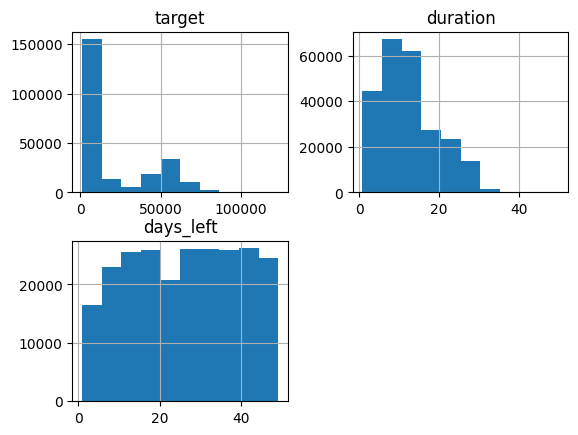

In [13]:
# 3.3 Univariate analysis - numerical features
df_train.hist()
plt.show()

<Axes: xlabel='days_left'>

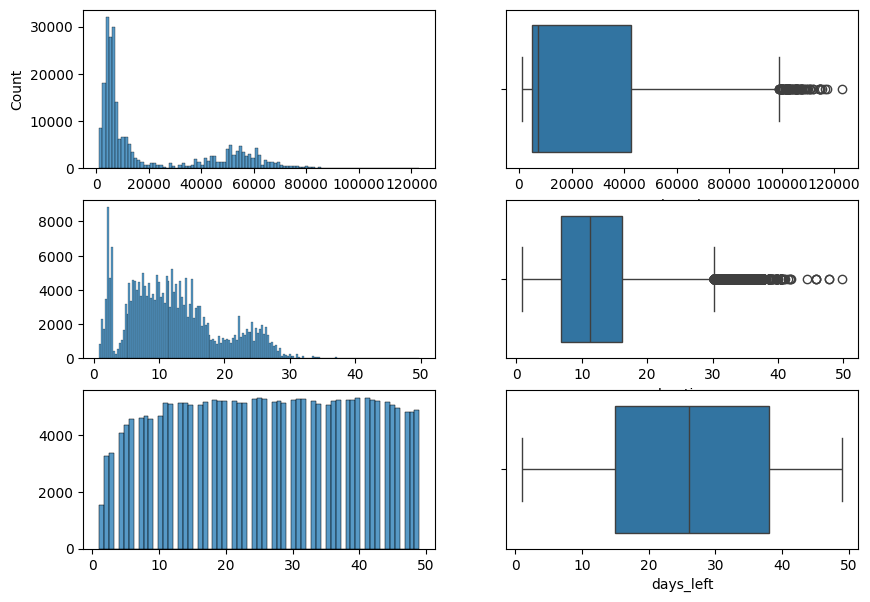

In [14]:
# 3.4 Outlier detection
fig, axis = plt.subplots(3, 2, figsize = (10, 7))
sns.histplot(ax = axis[0, 0], data = df_train, x= "target").set(xlabel = None)
sns.boxplot(ax = axis[0, 1], data = df_train, x = "target")
sns.histplot(ax = axis[1, 0], data = df_train, x = "duration").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = df_train, x = "duration")
sns.histplot(ax = axis[2, 0], data = df_train, x = "days_left").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[2, 1], data = df_train, x = "days_left")

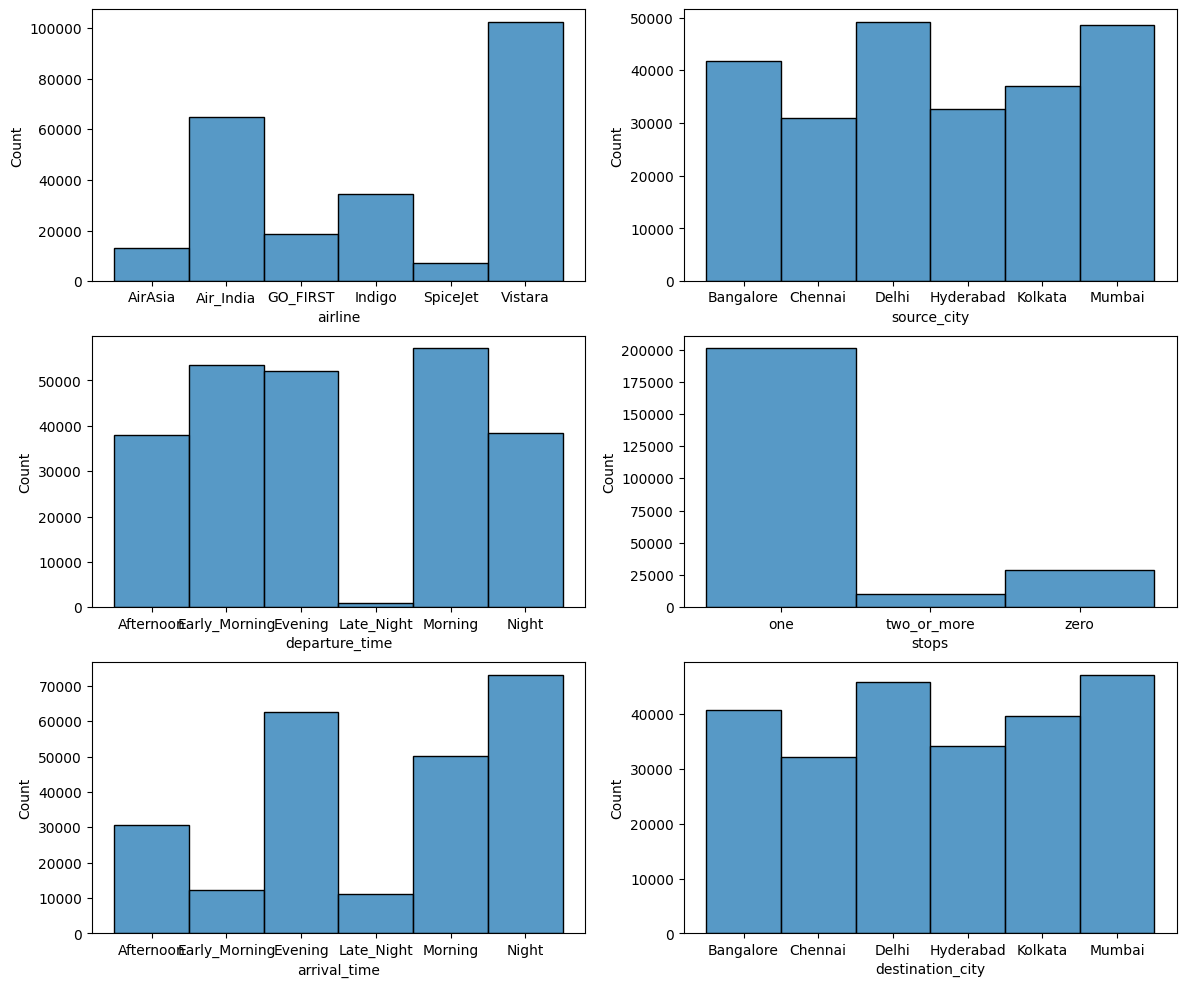

In [15]:
# 3.5 Univariate analysis - categorical features
fig, axis = plt.subplots(3, 2, figsize = (14, 12))
sns.histplot(ax = axis[0, 0], data = df_train, x = "airline")
sns.histplot(ax = axis[0, 1], data = df_train, x = "source_city")
sns.histplot(ax = axis[1, 0], data = df_train, x = "departure_time")
sns.histplot(ax = axis[1, 1], data = df_train, x = "stops")
sns.histplot(ax = axis[2, 0], data = df_train, x = "arrival_time")
sns.histplot(ax = axis[2, 1], data = df_train, x = "destination_city")
plt.show()

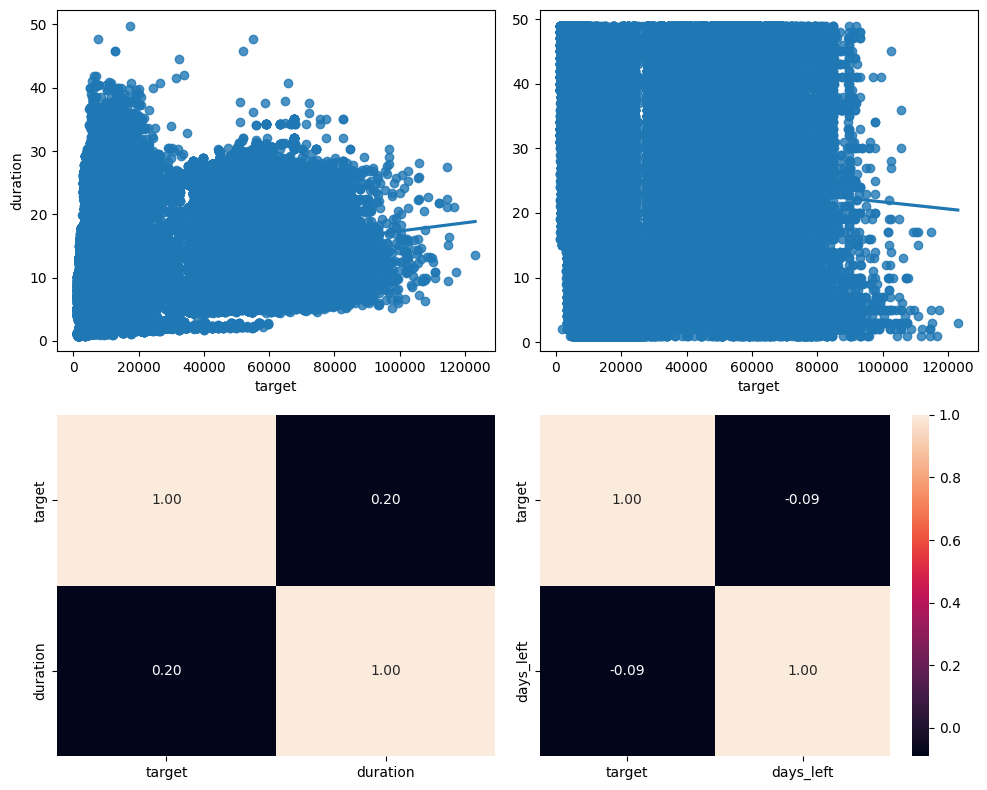

In [16]:
# 3.6 Bivariate analysis - numerical features
# Create a multiple scatter diagram
fig, axis = plt.subplots(2, 2, figsize=(10, 8))

# Graphics
sns.regplot(ax=axis[0, 0], data=df_train, x="target", y="duration")
sns.heatmap(df_train[["target", "duration"]].corr(), annot=True, fmt=".2f", ax=axis[1, 0], cbar=False)
sns.regplot(ax=axis[0, 1], data=df_train, x="target", y="days_left").set(ylabel=None)
sns.heatmap(df_train[["target", "days_left"]].corr(), annot=True, fmt=".2f", ax=axis[1, 1])

# Adjust design
plt.tight_layout()
plt.show()

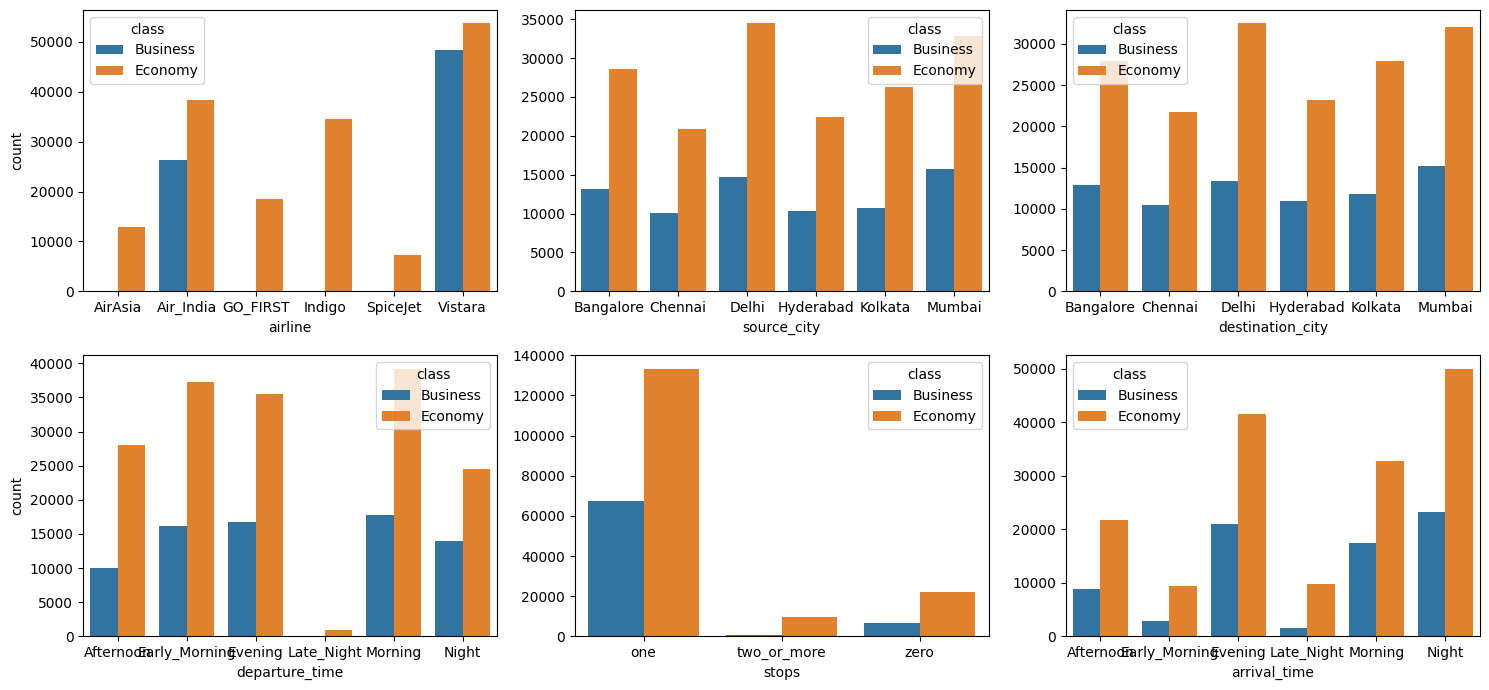

In [17]:
# 3.7 Bivariate analysis - categorical features

fig, axis = plt.subplots(2, 3, figsize = (15, 7))

sns.countplot(ax = axis[0, 0], data = df_train, x = "airline", hue = "class")
sns.countplot(ax = axis[0, 1], data = df_train, x = "source_city", hue = "class").set(ylabel = None)
sns.countplot(ax = axis[0, 2], data = df_train, x = "destination_city", hue = "class").set(ylabel = None)
sns.countplot(ax = axis[1, 0], data = df_train, x = "departure_time", hue = "class")
sns.countplot(ax = axis[1, 1], data = df_train, x = "stops", hue = "class").set(ylabel = None)
sns.countplot(ax = axis[1, 2], data = df_train, x = "arrival_time", hue = "class").set(ylabel = None)

plt.tight_layout()
plt.show()

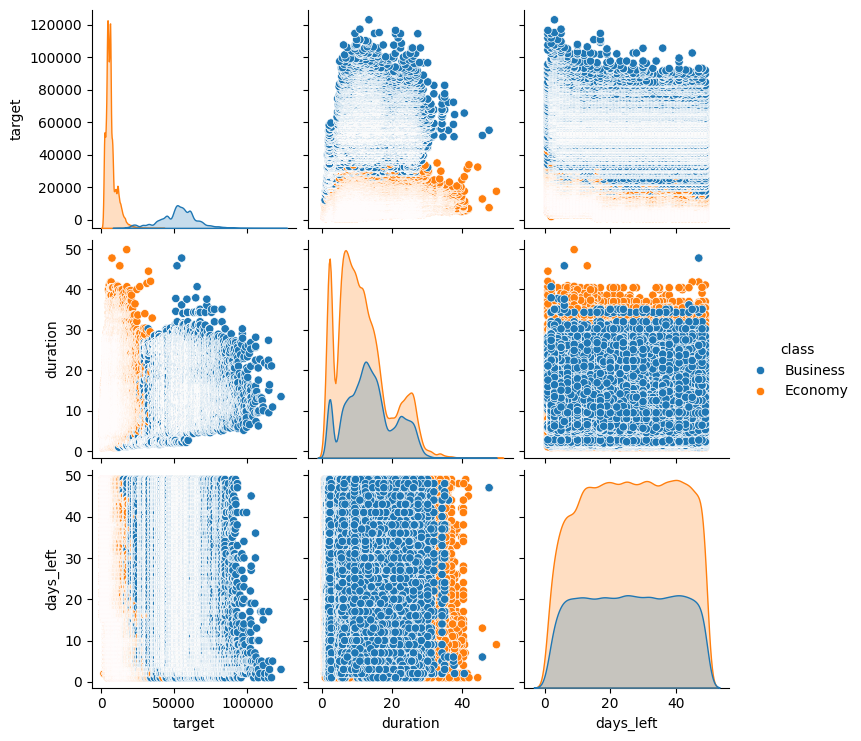

In [18]:
# 3.7 Bivariate analysis - categorical vs numerical features
sns.pairplot(data = df_train, hue = "class")
plt.show()

### 4. Machine learning
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [19]:
# 4.1 Get variables ready
inputs_cols=['airline',  'source_city', 'departure_time','stops', 'arrival_time',
            'destination_city', 'class', 'duration', 'days_left']
targets_col='target'

In [20]:
# 4.2 Create dataframes to transform
inputs_dataset = df[inputs_cols].copy()
targets_set    = df[targets_col].copy()

In [21]:
# 4.3 Separate numerical and categorical features
numeric_cols = inputs_dataset.select_dtypes(include=np.number).columns.tolist()
categorical_cols = inputs_dataset.select_dtypes(include='category').columns.tolist()

In [22]:
# 4.4 Scaling numerical features
scaler = MinMaxScaler()
scaler.fit(inputs_dataset[numeric_cols])
inputs_dataset[numeric_cols] = scaler.transform(inputs_dataset[numeric_cols])

In [23]:
# 4.5 Encoding categorical features
encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
encoder.fit(inputs_dataset[categorical_cols])
encoder_cols = encoder.get_feature_names_out(categorical_cols)
inputs_dataset[encoder_cols]=encoder.transform(inputs_dataset[categorical_cols])

In [24]:
# 4.6 Create stacked dataframe
X = pd.concat([inputs_dataset[numeric_cols], inputs_dataset[encoder_cols]],axis=1)
y = targets_set

In [25]:
# 4.6 Modeling
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)

In [26]:
# 4.7 Linear Regression Model
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [27]:
# 4.8 Linear Regression Prediction
pred = lr.predict(X_test)
pred

array([ 3430.125 , 55152.1875, 10415.125 , ...,  4960.125 , -1633.375 ,
       57505.4375])

In [28]:
# 4.9 Get metrics for Linear regression
lr_score= r2_score(y_test,pred)
lr_mse = mean_squared_error(y_test,pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test,pred)
print(f'MSE: {lr_mse:.2f}')
print(f'RMSE: {lr_rmse:.2f}')
print(f'MAE: {lr_mae:.2f}')
print(f'R2: {lr_score:.2f}')

MSE: 45720779.45
RMSE: 6761.71
MAE: 4553.41
R2: 0.91


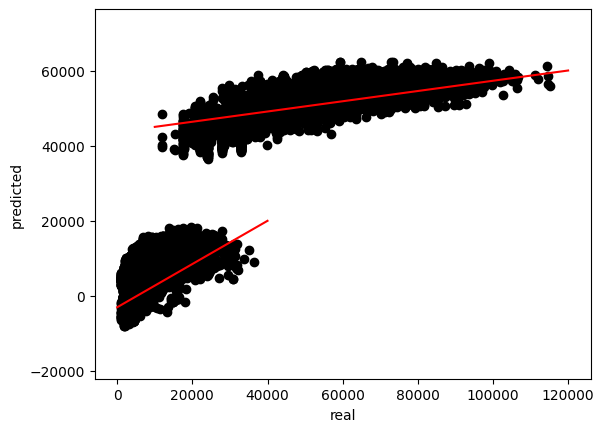

In [29]:
# 4.10 Graph predictions for Linear regression
plt.scatter(x= y_test, y= pred, c= 'k')
plt.plot([0,40000],[-3000,20000], c= 'r')
plt.plot([10000,120000],[45000,60000], c= 'r')
plt.axis('equal')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

The separation indicates the presence of 2 classes.


In [30]:
# 4.11 Decision Regression Model
dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)

DecisionTreeRegressor()

In [31]:
# 4.11 Prediction for Decision Regression Model
pred_dtr = dtr.predict(X_test)
pred_dtr

array([ 7366., 64831.,  6195., ...,  6314.,  4558., 70049.])

In [32]:
dtr_score= r2_score(y_test,pred_dtr)
dtr_score

0.975599052930719

In [33]:
dtr_mse = mean_squared_error(y_test,pred)
dtr_rmse = np.sqrt(dtr_mse)
dtr_mae = mean_absolute_error(y_test,pred)
print(f'MSE: {dtr_mse:.2f}')
print(f'RMSE: {dtr_rmse:.2f}')
print(f'MAE: {dtr_mae:.2f}')
print(f'R2: {dtr_score:.2f}')

MSE: 45720779.45
RMSE: 6761.71
MAE: 4553.41
R2: 0.98


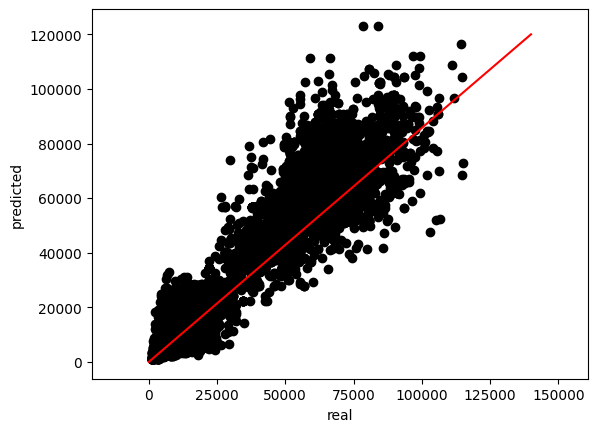

In [34]:
plt.scatter(x= y_test, y= pred_dtr, c= 'k')
plt.plot([0,140000],[0,120000], c= 'r')
plt.axis('equal')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

In [35]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor()

In [36]:
pred_rf = rf.predict(X_test)
pred_rf

array([ 7346.31, 67490.33,  6197.63, ...,  6472.72,  4106.51, 71670.96])

In [37]:
rf_score= r2_score(y_test,pred_rf)
rf_score

0.9848945505284717

In [38]:
rf_mse = mean_squared_error(y_test,pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test,pred)
print(f'MSE: {rf_mse:.2f}')
print(f'RMSE: {rf_rmse:.2f}')
print(f'MAE: {rf_mae:.2f}')
print(f'R2: {rf_score:.2f}')

MSE: 45720779.45
RMSE: 6761.71
MAE: 4553.41
R2: 0.98


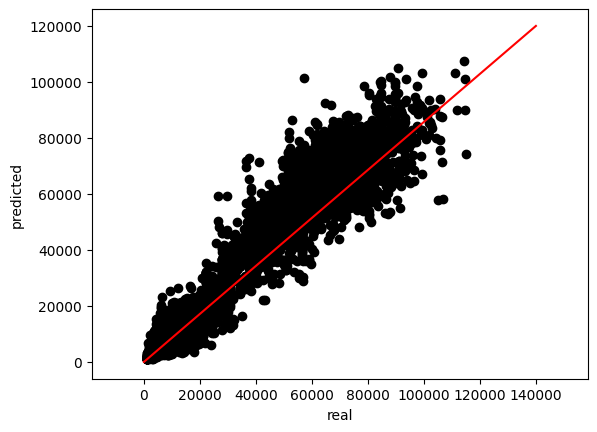

In [39]:
plt.scatter(x= y_test, y= pred_rf, c= 'k')
plt.plot([0,140000],[0,120000], c= 'r')
plt.axis('equal')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

In [40]:
comparission = pd.DataFrame({"algorithm": [], "MSE": [], "RMSE": [], "MAE": [], "R2": []})
algorithm_names = ["Linear Regression", "Decision Tree", "Random Forest"]
mse_values = [lr_mse, dtr_mse, rf_mse]
rmse_values = [lr_rmse, dtr_rmse, rf_rmse]
mae_values = [lr_mae, dtr_mae, rf_mae]
r2_values = [lr_score, dtr_score, rf_score]
comparission = pd.DataFrame({"algorithm": algorithm_names, "MSE": mse_values, "RMSE": rmse_values, "MAE": mae_values, "R2": r2_values})
comparission

,algorithm,MSE,RMSE,MAE,R2
0,Linear Regression,4.572078e+07,6761.714239,4553.408228,0.911305
1,Decision Tree,4.572078e+07,6761.714239,4553.408228,0.975599
2,Random Forest,4.572078e+07,6761.714239,4553.408228,0.984895


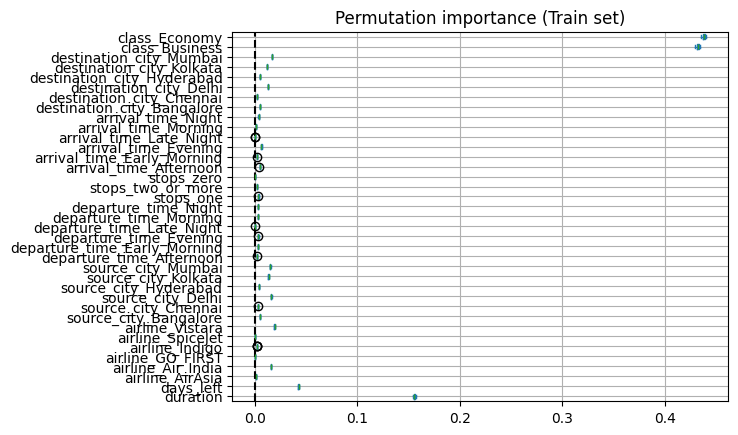

In [ ]:
# Calculate feauture importance
importance = permutation_importance(rf, X_train, y_train, n_repeats=25, random_state=2024)
importance_df = pd.DataFrame(importance.importances.T, columns=X_train.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0, color='k', linestyle='--')
ax.set_title('Permutation importance (Train set)')
ax.grid(True)
plt.show()

### 5. Operational Summary

Method: The dataset was segmented into categorical and numerical variables for analysis and processing prior to running the algorithm. The algorithms selected were Linear Regression, Decision Tree Regressor and Random Forest Regressor.

Findings: An RMSE of 6761.71 and an R2 of 0.98 were obtained for a test dataset of n=240122 entries. These optimal values were achieved with the Random Forest Regressor.

Interpretation: Our prediction was above the actual values, i.e. the demand was overestimated. In the analysis of the importance of variables, it was observed that class and duration were the variables that had the greatest impact on the prediction.


In [41]:
# Save the model for further usage
# Create model dictionary
model_dict = {
    'model': lr,
    'predictors': X_train.columns.to_list(),
    'target_name': y_train.name,
    'algorithm_name': 'Linear regression'
}

In [42]:
# 6.2 Save the model dictionary
try:
    joblib.dump(model_dict, 'flight_price_prediction_lr.joblib')
    logger.info("Save succesful")
except Exception as e:
    logger.error(f"An error occurred: {e}")